# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [54]:
!pip install pyarabic

In [55]:
from pyarabic.araby import strip_tashkeel, normalize_hamza

# Download the Dataset

In [56]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
spam-messages.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spam-messages.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spam.csv                


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [57]:
import pandas as pd
data = pd.read_csv('spam.csv')

data.head()


,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [58]:
data['text']

,text
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
...,...
5567,This is the 2nd time we have tried 2 contact u...
5568,Will Ì_ b going to esplanade fr home?
5569,"Pity, * was in mood for that. So...any other s..."
5570,The guy did some bitching but I acted like i'd...


In [59]:
missing_values = data.isnull().sum()
missing_values

,0
text,0
label,0


In [60]:
label_distribution = data['label'].value_counts()
label_distribution

,count
label,
ham,4825
spam,747


since the distrution is unbalanced, we should remove and match it with the minority class

In [61]:
import pandas as pd
from sklearn.utils import resample

# Separating majority and minority classes
data_majority = data[data.label == 'spam']
data_minority = data[data.label == 'ham']

# Upsampling minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,
                                 n_samples=len(data_majority),    # Matching the majority class
                                 random_state=42)

data = pd.concat([data_majority, data_minority_upsampled])

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"New class distribution: \n{data['label'].value_counts()}")


New class distribution: 
label
ham     747
spam    747
Name: count, dtype: int64


<Axes: >

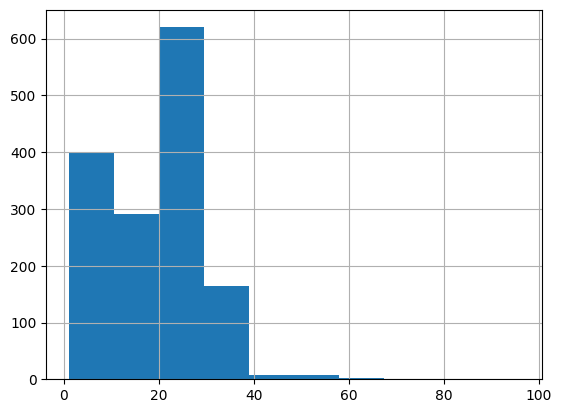

In [62]:
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
data['text_length'].hist()

<Axes: >

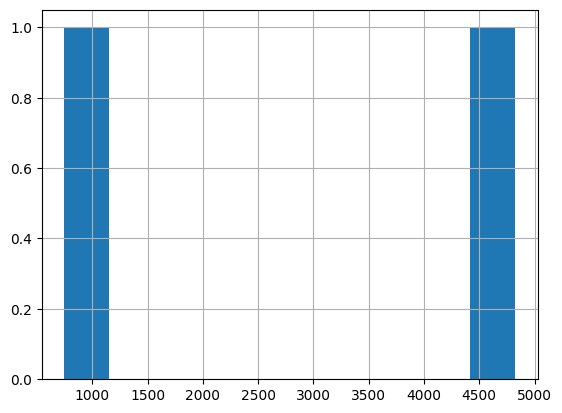

In [63]:
label_distribution.hist()

In [64]:
from collections import Counter
all_words = ' '.join(data['text']).split()
common_words = Counter(all_words).most_common(30)
common_words


[('to', 824),
 ('a', 507),
 ('you', 363),
 ('the', 324),
 ('https://link1.com', 252),
 ('https://link2.com', 243),
 ('your', 237),
 ('https://link3.com', 233),
 ('for', 233),
 ('I', 224),
 ('is', 220),
 ('2', 214),
 ('and', 214),
 ('or', 209),
 ('call', 206),
 ('on', 180),
 ('of', 174),
 ('have', 172),
 ('in', 166),
 ('ur', 151),
 ('Call', 140),
 ('are', 140),
 ('from', 139),
 ('with', 136),
 ('u', 133),
 ('4', 123),
 ('i', 117),
 ('U', 117),
 ('You', 107),
 ('me', 105)]

In [65]:
data['text'].unique()

array(['Pls give her the food preferably pap very slowly with loads of sugar. You can take up to an hour to give it. And then some water. Very very slowly. https://link3.com',
       'Ok lor. Anyway i thk we cant get tickets now cos like quite late already. U wan 2 go look 4 ur frens a not? Darren is wif them now... https://link2.com',
       "Oh k...i'm watching here:) https://link3.com", ...,
       'Nah im goin 2 the wrks with j wot bout u?',
       'First has she gained more than  &lt;#&gt; kg since she took in. Second has she done the blood sugar tests. If she has and its ok and her blood pressure is within normal limits then no worries',
       'Ok ok take care. I can understand.'], dtype=object)

In [66]:
data['text_length'].unique()

array([31,  5, 18, 10, 26, 32, 28, 22, 25, 19, 23, 12, 13, 27, 30,  8, 24,
       34,  7, 21,  9,  1, 11,  6, 29, 64, 17, 14, 16,  2, 57,  4, 35, 15,
        3, 33, 50, 39, 20, 36, 38, 49, 43, 52, 96, 56, 37, 72, 58, 40, 42,
       41])

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [67]:
missing_values = data.isnull().sum()
missing_values

,0
text,0
label,0
text_length,0


In [68]:
# Filtering out rows with text that is too short or too long
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

min_length = 5
max_length = 100

data = data[(data['text_length'] >= min_length) & (data['text_length'] <= max_length)]
print("Data after filtering:\n", data.head())


Data after filtering:
                                                 text label  text_length
0  Pls give her the food preferably pap very slow...   ham           31
1  Ok lor. Anyway i thk we cant get tickets now c...   ham           31
2       Oh k...i'm watching here:) https://link3.com   ham            5
3  Oh gei. That happend to me in tron. Maybe ill ...   ham           18
4  How much would it cost to hire a hitman https:...   ham           10


In [69]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')


english_stopwords = stopwords.words('english')
print(english_stopwords[:10])
# importing english stopwords and downloading it


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))
print("English Stopwords Loaded:\n", english_stopwords)


English Stopwords Loaded:
 {'she', 'ma', 'now', "that'll", "doesn't", 'or', 'again', 'won', 'don', "you've", 'will', 'herself', 'few', 'more', 've', "wasn't", 'couldn', 'hasn', 'other', 'while', "aren't", 'here', 'll', 'was', 'be', 'when', "weren't", 'shan', 'with', 'ours', 'his', 'has', 're', 'very', 'own', 'all', 'wouldn', 'any', 'and', 'doesn', 'through', 'didn', 'so', 'off', 'ourselves', 'against', 'because', "should've", 'himself', 'were', 'who', 'some', 'this', 'myself', 'just', 'm', 'mustn', 't', 'but', 'these', 'by', 'in', 'yourself', 'him', "she's", 'once', 'isn', 'too', 'both', 'doing', 'under', 'only', 'itself', "won't", 'why', "mightn't", 'what', 'can', "you're", 'below', 'up', 'that', 'theirs', 'i', 'haven', 'y', 'on', "isn't", 'which', 'he', "mustn't", 'during', 'aren', 'have', 'above', 'of', 'as', 'about', 'not', 'our', "haven't", 'same', "you'd", 'being', 'my', 'how', 'those', 'each', "don't", "needn't", 'until', 'than', 'ain', "shouldn't", 'from', 'no', 'down', 'hadn',

In [71]:
import re

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

data['text'] = data['text'].apply(remove_urls)
print("Text after removing URLs:\n", data['text'].head())


Text after removing URLs:
 0    Pls give her the food preferably pap very slow...
1    Ok lor. Anyway i thk we cant get tickets now c...
2                          Oh k...i'm watching here:) 
3    Oh gei. That happend to me in tron. Maybe ill ...
4             How much would it cost to hire a hitman 
Name: text, dtype: object


<ipython-input-71-11fe9c90536f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(remove_urls)


In [72]:
import re

def remove_special_characters(text):
    # This regex removes everything that is not a word character
    return re.sub(r'[^\w\s]', '', text)

# used to avoid the SettingWithCopyWarning - debugging step
data.loc[:, 'text'] = data['text'].apply(remove_special_characters)

print("Text after removing special characters:\n", data['text'].head())


Text after removing special characters:
 0    Pls give her the food preferably pap very slow...
1    Ok lor Anyway i thk we cant get tickets now co...
2                                Oh kim watching here 
3    Oh gei That happend to me in tron Maybe ill dl...
4             How much would it cost to hire a hitman 
Name: text, dtype: object


In [73]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in english_stopwords])

In [74]:
from nltk.stem.isri import ISRIStemmer

stemmer = ISRIStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [75]:
def clean_text(text):
    text = text.lower()
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

data.loc[:, 'cleaned_text'] = data['text'].apply(clean_text)
print("Final cleaned text:\n", data['cleaned_text'].head())

Final cleaned text:
 0    pls give food preferably pap slowly loads suga...
1    ok lor anyway thk cant get tickets cos like qu...
2                                      oh kim watching
3                  oh gei happend tron maybe ill dl 3d
4                          much would cost hire hitman
Name: cleaned_text, dtype: object


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer

# As
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned_text'])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")


Found 4540 unique tokens.


In [77]:
data.isnull().sum()

,0
text,0
label,0
text_length,0
cleaned_text,0


In [82]:
# Converting the text to sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# printing the first sequence to verify
sequences[0]


[119, 120, 761, 2161, 2162, 543, 1288, 960, 90, 419, 120, 1289, 543]

In [83]:
from keras.preprocessing.sequence import pad_sequences

#  maximum sequence length
max_length = 100

# Padding the sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

padded_sequences[0]


array([ 119,  120,  761, 2161, 2162,  543, 1288,  960,   90,  419,  120,
       1289,  543,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

# After splitting, we perform label encoding on the training data only

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Only transforming the test labels, not fitting again

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (1156, 100)
Testing data shape: (289, 100)
Training labels shape: (1156,)
Testing labels shape: (289,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [87]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN, Bidirectional
from keras.layers import Dense
from keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, 100))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [88]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 128)            │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,391,873 (5.31 MB)

 Trainable params: 1,391,873 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [90]:
import tensorflow as tf

batch_size = 32

# Creating Datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batching the Datasets
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

epochs = 10
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)


training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 417ms/step - accuracy: 0.6556 - loss: 0.6084 - val_accuracy: 0.9239 - val_loss: 0.2191
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.9661 - loss: 0.1050 - val_accuracy: 0.9550 - val_loss: 0.1418
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.9996 - loss: 0.0053 - val_accuracy: 0.9377 - val_loss: 0.3144
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - accuracy: 0.9978 - loss: 0.0092 - val_accuracy: 0.9446 - val_loss: 0.2176
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 1.0000 - loss: 3.2961e-04 - val_accuracy: 0.9446 - val_loss: 0.2736
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 1.0000 - loss: 1.4492e-04 - val_accuracy: 0.9446 - val_loss: 0.2689
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 1.0000 - loss: 1.0409e-04 - val_accuracy: 0.9446 - val_loss: 0.2680
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 1.0000 - loss: 8.1507

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9282 - loss: 0.3746
Test Loss: 0.2725
Test Accuracy: 0.9481


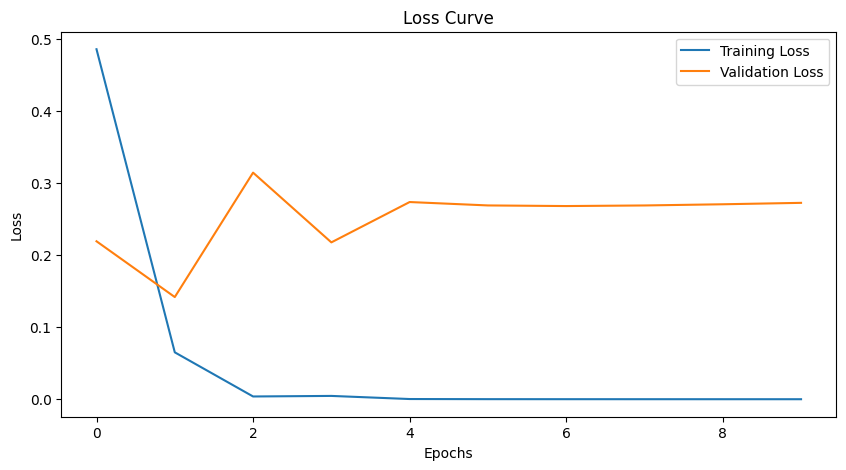

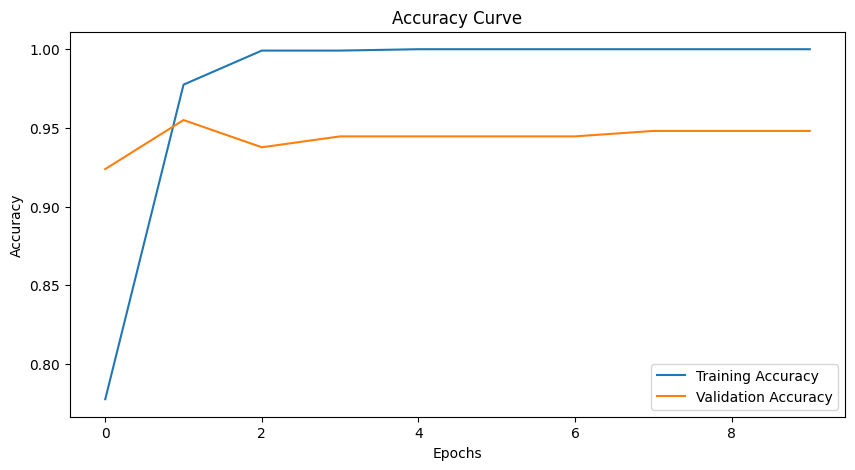

In [91]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [103]:
s_texts = [
    "Congratulations! You've won ten million dollars. Click this link claim your prize.",
    "URGENT: Your account has been suspended. Send your password to restore access."
]
h_texts = [
    "Hey, just wanted to check in and see how you're doing.",
    "Are you coming to the meeting tomorrow?",
    "Dear Rakan, Just checking about the project, is everything going on track?",
    "URGENT: Your account has been suspended. Click here to restore access."
]


In [104]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_texts(texts, tokenizer, model, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    predictions = model.predict(padded_sequences)

    for i, prediction in enumerate(predictions):
        prediction_value = prediction[0]
        label = "spam" if prediction_value > 0.5 else "ham"
        print(f"Text: '{texts[i]}'")
        print(f"Predicted Label: {label}\n")

predict_texts(s_texts, tokenizer, model, max_length)
predict_texts(h_texts, tokenizer, model, max_length)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Text: 'Congratulations! You've won ten million dollars. Click this link claim your prize.'
Predicted Label: spam

Text: 'URGENT: Your account has been suspended. Send your password to restore access.'
Predicted Label: spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: 'Hey, just wanted to check in and see how you're doing.'
Predicted Label: ham

Text: 'Are you coming to the meeting tomorrow?'
Predicted Label: ham

Text: 'Dear Rakan, Just checking about the project, is everything going on track?'
Predicted Label: ham

Text: 'URGENT: Your account has been suspended. Click here to restore access.'
Predicted Label: spam



# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

- 1- I deleted URLs, special characters, converted the texts to lower case, and removed stopwords to simplify the text. It's a vital step to focus on important words only, to improve the model's performance.
- 2- I used SimpleRNN first, but then it was overfitting easily, so i decided to go with GRU because it captures context from both directions, which is essential for understanding the text better.
- 3- I chose two GRU layers with 64 and 32 units to balance learning complex patterns without making the model too large or prone to overfitting.
- 4- I used accuracy and binary crossentropy loss to evaluate how well the model is performing overall and to monitor its learning process.
- 5- Yes the model shows overfitting since the training accuracy reached 100, but validation accuracy didnt improve that much and validation loss started to increase.
- 6- Dropout layers, reducing the number of units, or early stopping.
####Note: my model wasn't overfitting heavily, it was still able to predict on unseen data well enough, however, it could be improved by using one of the steps mentioned above or other things like regularization, decreasing the learning rate, or changing the number of nuerons.